### Project Description
This tool can be used to fit EIS data generated from inhomogenous porous eletrodes. 

### Import the needed modules

In [28]:
%matplotlib ipympl
from models import *
# from models import find_index_of_nearest
from impedance.preprocessing import readCSV, readBioLogic
from impedance.visualization import plot_nyquist,plot_bode
from impedance.models.circuits import CustomCircuit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from arbitau import give_z_for_arbitary_tau, tau_plotter
from scipy.integrate import solve_bvp

## Bring and plot your EIS data here
Check if its has come as it is

your first column should contain the frequency values, second column should contain the real part of the impedance, the third column should contain the imaginary part of the impedance

Please order the data in either ascending or descending order of frequency values

In [29]:
#can provide csv or mpt files, keep the data file in the same folder as this jupyter file
#for example:
#freq_list, zexp = readCSV("./name_of_your_file.csv")

freq_list, zexp = readCSV("./zdata3.csv")

#Below are some examples what type of data can be brought
#freq, zexp = readBioLogic("exampleData.mpt")
#freq, zexp = readCSV("hello.csv")

### Generate Synthetic Exp Data
We can generate synthetic data using any of our four default available profiles,
Or we can even generate the impedance data for any arbitray tortuosity profile given as a function of thickness fraction of electrode (this function should be a continous and differentiable function of x from x=0 to 1)

In [3]:
freq_list=np.logspace(-1,2,100)

##### Arbitary Tortuosity Profile

[414.10866151-4829.41429457j 414.01181941-4505.85494967j
 413.90055898-4204.24017495j 413.77274801-3923.1005863j
 413.62594364-3661.06644522j 413.45734853-3416.86096911j
 413.26376143-3189.29409022j 413.0415214 -2977.25663202j
 412.78644519-2779.71487342j 412.49375723-2595.70547326j
 412.15801157-2424.33072867j 411.77300547-2264.75414247j
 411.33168438-2116.19627598j 410.82603817-1977.93086432j
 410.24698898-1849.28117268j 409.58427157-1729.61657238j
 408.82630751-1618.34931635j 407.96007565-1514.9314944j
 406.97098234-1418.85214898j 405.8427363 -1329.63453293j
 404.55723501-1246.83349154j 403.09447139-1170.03295219j
 401.43247241-1098.8435065j  399.54728395-1032.900072j
 397.41301956 -971.85962366j 395.00199373 -915.39898973j
 392.28496327 -863.21271216j 389.23150244 -815.01097947j
 385.81053783 -770.51764913j 381.99106718 -729.46838742j
 377.74308099 -691.60896716j 373.03869567 -656.69377593j
 367.85349193 -624.48459899j 362.16803044 -594.74974848j
 355.9694903  -567.2636124j  349.25

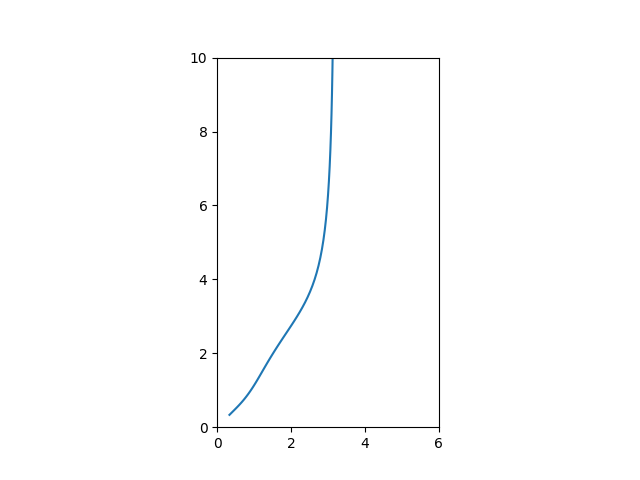

In [4]:
fig, ax=plt.subplots()
def tau9(x):
    return 5+np.tanh(x*10-5)+2*np.tanh(x*10-4)
zexp=give_z_for_arbitary_tau(tau9,freq_list,ax,"τ=*")
print(zexp)

##### Default Tortuosity Profiles

In [22]:
#parameter for the TLM
Q=1e-6
alpha=1

R1=400
delta1=0.3
R2=400
R3=400
delta2=0.3


#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
Rhfr=40
Rrxn=40
Qdl=1e-6
alpha2=1

#For Two-step provide R1,R2,Q,delta1,alpha
#For Three-step provide R1,R2,R3,Q,delta1,delta2,alpha
#For Linear provide R1,R2,Q,alpha
#For Inv-Linear provide R1,R2,Q,alpha

###For arbitary profile provide <what?>###
#write the profile that you want to fit
#tau should remain >=1 in the entire domain of the electrode
#for example, tau=1+np.sin(2*x)

In [23]:
#---uncomment the line below for fitting the uniform tortuosity profile---
#cmodel=CustomCircuit(initial_guess=[R1,Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMuni_1-R_1-p(R_2,CPE_1)")

#cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMtwo_1-R_1-p(R_2,CPE_1)")

cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,R3*Q,delta1,delta2,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMthree_1-R_1-p(R_2,CPE_1)")

# cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMlin_1-R_1-p(R_2,CPE_1)")

# cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMilin_1-R_1-p(R_2,CPE_1)")

In [5]:
zexp=cmodel.predict(frequencies=freq_list)

NameError: name 'cmodel' is not defined

### Plot the impedance Data

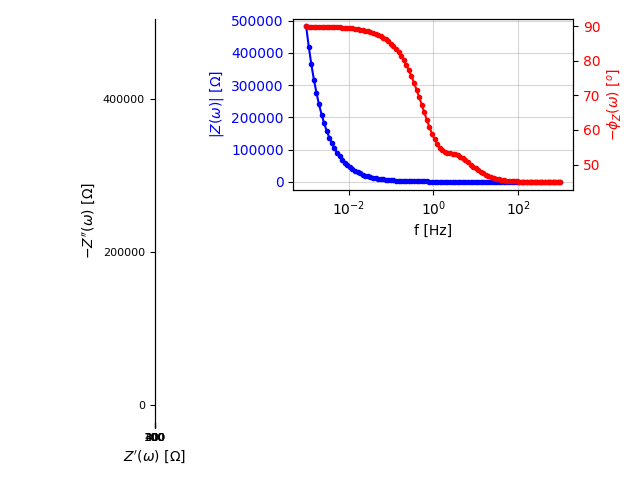

In [30]:
fig= plt.figure()
ax_nyq=fig.add_subplot(121)
ax_mag=fig.add_subplot(222)
ax_phs=ax_mag.twinx()

#plot nyquist plot of the taken data
plot_nyquist(zexp,ax=ax_nyq,labelsize=10,ticksize=8)

#plot bode plot of the taken data
ax_mag.plot(freq_list, np.abs(zexp), '.-', color="blue")
ax_phs.plot(freq_list, -np.angle(zexp, deg=True), '.-',color="red")
ax_mag.set_ylabel(r'$|Z(\omega)|$ ' +'$[{}]$'.format("Ω"), fontsize=10,color="blue")
ax_phs.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10,color="red")
ax_mag.set_xlabel('f [Hz]', fontsize=10)
ax_mag.set_xscale('log')
ax_mag.tick_params(axis='y', labelcolor="blue")
ax_phs.tick_params(axis='y', labelcolor="red")
ax_mag.grid(visible=True, which='major', axis='both', alpha=.5)
fig.tight_layout()

### Provide the frequency range in which you want to fit

In [31]:
f_high=1e1   #high
f_low=1e-1   #Low

#high low should be between the actual available range of freq, not out of that otherwise how will we have the impedance data at those frequencies
fhigh_idx=find_index_of_nearest(freq_list,f_high)
flow_idx=find_index_of_nearest(freq_list,f_low)
print(fhigh_idx," ",flow_idx)

#crop the data, that falls in this frequency range
if(fhigh_idx<flow_idx):
    freq_to_fit=freq_list[fhigh_idx:flow_idx]
    zexp_to_fit=zexp[fhigh_idx:flow_idx]
else:
    freq_to_fit=freq_list[flow_idx:fhigh_idx]
    zexp_to_fit=zexp[flow_idx:fhigh_idx]


66   33


##### See the data for the freq range that you have choosen

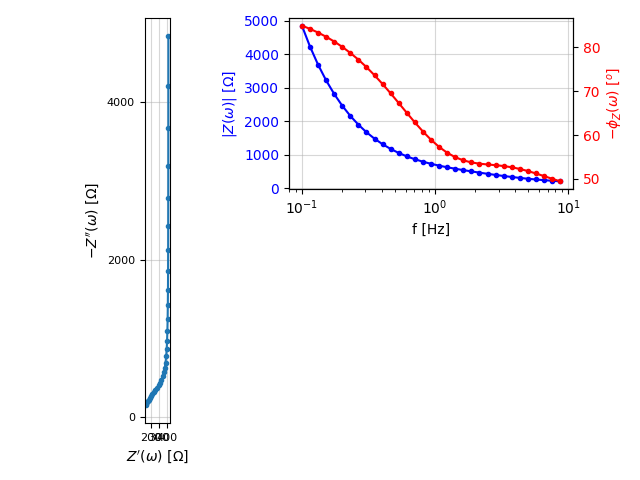

In [32]:
##-----------##
#put the nyquist and the bode plot on the same figure

fig= plt.figure()
ax_nyq=fig.add_subplot(121)
ax_mag=fig.add_subplot(222)
ax_phs=ax_mag.twinx()

#plot nyquist plot of the taken data
plot_nyquist(zexp_to_fit,ax=ax_nyq,labelsize=10,ticksize=8)

#plot bode plot of the taken data
mag_color="blue"
phs_color="red"
ax_mag.plot(freq_to_fit, np.abs(zexp_to_fit), '.-', color=mag_color)
ax_phs.plot(freq_to_fit, -np.angle(zexp_to_fit, deg=True), '.-',color=phs_color)
ax_mag.set_ylabel(r'$|Z(\omega)|$ ' +'$[{}]$'.format("Ω"), fontsize=10,color=mag_color)
ax_phs.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10,color=phs_color)
ax_mag.set_xlabel('f [Hz]', fontsize=10)
ax_mag.set_xscale('log')
ax_mag.tick_params(axis='y', labelcolor=mag_color)
ax_phs.tick_params(axis='y', labelcolor=phs_color)
ax_mag.grid(visible=True, which='major', axis='both', alpha=.5)
fig.tight_layout()

#### Choose the inhomogenity profile of tortuosity and provide the initial guesses for the parameters
The following profiles are available

1. Uniform tortuosity
2. Two-Step inhomogenity in tortuosity
3. Three-Step
4. Linearly varying toruosity
5. Inverse-Linear

You can also select all the profiles at once and see which one fits better:
using the ...........(to be conti.)


In [10]:
#initial guesses for the TLM
#Double layer Capacitance inside porous electrode
Q=6.61e-4
alpha=1

R1=400
delta1=0.3
R2=400

R3=400
delta2=0.3


#initial guesses for the HFR intercept and for any semicircle like features in the EIS data
Rhfr=200
Rrxn=200
Qdl=6.61e-4
alpha2=1

#other (for arbitrary tortuosity profile)
Rref=200
a=4
b=5

#For Two-step provide R1,R2,Q,delta1,alpha
#For Three-step provide R1,R2,R3,Q,delta1,delta2,alpha
#For Linear provide R1,R2,Q,alpha
#For Inv-Linear provide R1,R2,Q,alpha

###For arbitary profile provide <what?>###
#write the profile that you want to fit
#tau should remain >=1 in the entire domain of the electrode
#for example, tau=1+np.sin(2*x)

### Choose any of the default profiles

In [33]:
#---uncomment the line below for fitting the uniform tortuosity profile---

#cmodel=CustomCircuit(initial_guess=[R1,Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMuni_1-R_1-p(R_2,CPE_1)")

cmodel5=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMtwo_1-R_1-p(R_2,CPE_1)")

#cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,R3*Q,delta1,delta2,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMthree_1-R_1-p(R_2,CPE_1)")

# cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMlin_1-R_1-p(R_2,CPE_1)")

# cmodel=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMilin_1-R_1-p(R_2,CPE_1)")


### Provide an arbitray Tortuosity Profile

In [11]:
#-- uncomment the line below for fitting an arbitrary tortuosity profile--#

@element(num_params=4,units=["","","",""],overwrite=True)
def arbitau(p,f):
    # modify the number of parameters according to the torutosity function
    Rref, Q, a, b = p[0], p[1], p[2], p[3]
    # provide the definition for the arbitrary tortuosity function
    
    def tau(x):
        # return 5+np.tanh(x*10-3)+2*np.tanh(x*10-5)
        return 5+np.tanh(x*10-a)+2*np.tanh(x*10-b)
    
    def fun(x,y,lmd):
        return np.vstack((y[2]*tau(x),y[3]*tau(x),-lmd*y[1],lmd*y[0]))

    def bc(ya,yb):
        return np.array([ya[0]-1,yb[2],yb[3],ya[1]])

    # Q=6.61e-4
    # Rref=194.56

    x=np.linspace(0,1,1000)
    y=np.zeros((4,x.size))
    # print(y)

    Z_list=np.zeros((np.size(np.array(f))),dtype=complex)
    # print(Z_list)
    ii=0
    for freq in np.array(f):
        w=2*np.pi*freq
        lmd2=w*Q*Rref
        sol1 = solve_bvp(lambda x,y: fun(x,y,lmd=lmd2), bc, x, y)
        y3=sol1.sol(x)[2]
        y4=sol1.sol(x)[3]
        Z=2/(-(1/(Rref))*(y3[0]+y4[0]*1j))
        Z_list[ii]=Z
        ii=ii+1

    return Z_list

@element(num_params=5,units=["","","","",""],overwrite=True)
def arbitaualha(p,f):
    # modify the number of parameters according to the torutosity function
    Rref, Q, alpha, a, b = p[0], p[1], p[2], p[3], p[4]
    # provide the definition for the arbitrary tortuosity function
    
    def tau(x):
        # return 5+np.tanh(x*10-3)+2*np.tanh(x*10-5)
        return 5+np.tanh(x*10-a)+2*np.tanh(x*10-b)
    
    def fun(x,y,lmdcos,lmdsin):
        return np.vstack((y[2]*tau(x),y[3]*tau(x),lmdcos*y[0]-lmdsin*y[1],lmdcos*y[1]+lmdsin*y[0]))

    def bc(ya,yb):
        return np.array([ya[0]-1,yb[2],yb[3],ya[1]])

    # Q=6.61e-4
    # Rref=194.56

    x=np.linspace(0,1,1000)
    y=np.zeros((4,x.size))
    # print(y)

    Z_list=np.zeros((np.size(np.array(f))),dtype=complex)
    # print(Z_list)
    ii=0
    for freq in np.array(f):
        w=2*np.pi*freq
        lmdcos=w**alpha*Q*Rref*np.cos(alpha*np.pi/2)
        lmdsin=w**alpha*Q*Rref*np.sin(alpha*np.pi/2)
        sol1 = solve_bvp(lambda x,y: fun(x,y,lmdcos=lmdcos,lmdsin=lmdsin), bc, x, y)
        y3=sol1.sol(x)[2]
        y4=sol1.sol(x)[3]
        Z=2/(-(1/(Rref))*(y3[0]+y4[0]*1j))
        Z_list[ii]=Z
        ii=ii+1

    return Z_list

# cmodel=CustomCircuit(initial_guess=[Rref,Q,a,b,Rhfr,Rrxn,Qdl,alpha2],circuit="arbitau_1-R_1-p(R_2,CPE_1)")
cmodel=CustomCircuit(initial_guess=[Rref,Q,a,b],circuit="arbitau_1")
# cmodel1=CustomCircuit(initial_guess=[Rref,Q,1,a,b,Rhfr,Rrxn,Qdl,alpha2],circuit="arbitaualha_1-R_1-p(R_2,CPE_1)")
cmodel1=CustomCircuit(initial_guess=[Rref,Q,1,a,b],circuit="arbitaualha_1")
cmodel2=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,R3*Q,delta1,delta2,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMthree_1-R_1-p(R_2,CPE_1)")

# print(cmodel)
# zzz=cmodel.predict(frequencies=freq_to_fit)
zzz1=cmodel1.predict(frequencies=freq_to_fit)
# zzz2=cmodel2.predict(frequencies=freq_to_fit)
# print(zzz)
print(zzz1)
# print(zzz2)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\impedance\models\circuits\circuits.py:144: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")


[400.86750171-4828.24388047j 400.78167307-4504.60065169j
 400.68306171-4202.89609284j 400.569776  -3921.66043073j
 400.43964825-3659.5235182j  400.29019568-3415.2081449j
 400.11857627-3187.52379727j 399.92153893-2975.36083636j
 399.69536748-2777.68506446j 399.43581783-2593.53265262j
 399.13804794-2422.00540342j 398.79653999-2262.26632401j
 398.40501462-2113.53548612j 397.95633683-1975.08615073j
 397.44241408-1846.24113591j 396.85408671-1726.36940729j
 396.18101211-1614.88287115j 395.41154437-1511.23335099j
 394.53261212-1414.90972881j 393.52959878-1325.43523295j
 392.38623067-1242.36485524j 391.08448053-1165.28288088j
 389.60449625-1093.80051588j 387.92456708-1027.5535987j
 386.02114265 -966.20038533j 383.86892287 -909.41940045j
 381.44103996 -856.90735249j 378.70935572 -808.37711642j
 375.64489856 -763.55579646j 372.21846402 -722.18289021j
 368.40139868 -684.00858724j 364.16658016 -648.79224644j
 359.48959348 -616.301108j   354.35008652 -586.30930462j
 348.73326383 -558.59724072j 342.

### Choose weighing method and the algorithm for the fitting

In [35]:
#wt="unit"
wt="mod"
#wt="prop"

def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))
    
#cmodel.fit(impedance=zexp,frequencies=freq,sigma=give_weights(zexp,wt),bounds=[(0,0,0.5,0.5),(np.inf,np.inf,1)])

##Three Step Fitting
#cmodel.fit(impedance=zexp,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0,0,0,0,0.5,0,0,0,0.5),(np.inf,np.inf,np.inf,np.inf,1,1,1,np.inf,np.inf,np.inf,1)])

#cmodel.fit(impedance=zout,frequencies=f,bounds=[(0,0,0,0,0,0,0.5),(np.inf,np.inf,np.inf,np.inf,1,1,1)])
    
# cmodel5=CustomCircuit(initial_guess=[R1,R1*Q,R2*Q,delta1,alpha,Rhfr,Rrxn,Qdl,alpha2],circuit="TLMtwo_1-R_1-p(R_2,CPE_1)")

cmodel5.fit(impedance=zexp,frequencies=freq_list,bounds=[(0,0,0,0,0.5,0,0,0,0.5),(np.inf,np.inf,np.inf,1,1,np.inf,np.inf,np.inf,1)])
#cmodel.fit(impedance=zout,frequencies=f,bounds=[(0,0,0,0.5),(np.inf,np.inf,np.inf,1)])

# print(give_weights(zexp,wt))
# print(zexp)

# fit the arbitrary profile with a and b as unknowns
# cmodel.fit(impedance=zexp,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0,0,0,0,0,0.5),(np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,1)])



#cmodel.fit(impedance=zexp,frequencies=freq_list,bounds=[(0,0,0,0,0,0,0,0.5),(np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,1)])
# cmodel.fit(impedance=zexp,frequencies=freq_list,bounds=[(0,0,0,0),(np.inf,np.inf,np.inf,np.inf)])
# cmodel1.fit(impedance=zexp,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0.5,0,0,0,0,0,0.5),(np.inf,np.inf,1,np.inf,np.inf,np.inf,np.inf,np.inf,1)])

# cmodel1.fit(impedance=zexp,frequencies=freq_list,sigma=give_weights(zexp,wt),bounds=[(0,0,0.5,0,0),(np.inf,np.inf,1,np.inf,np.inf)])

print(cmodel5)


Circuit string: TLMtwo_1-R_1-p(R_2,CPE_1)
Fit: True

Initial guesses:
  TLMtwo_1_0 = 4.00e+02 [Ohm]
  TLMtwo_1_1 = 2.64e-01 [Ohm F]
  TLMtwo_1_2 = 2.64e-01 [Ohm F]
  TLMtwo_1_3 = 3.00e-01 []
  TLMtwo_1_4 = 1.00e+00 []
    R_1 = 2.00e+02 [Ohm]
    R_2 = 2.00e+02 [Ohm]
  CPE_1_0 = 6.61e-04 [Ohm^-1 sec^a]
  CPE_1_1 = 1.00e+00 []

Fit parameters:
  TLMtwo_1_0 = 3.53e+02  (+/- 4.14e+00) [Ohm]
  TLMtwo_1_1 = 2.33e-01  (+/- 2.74e-03) [Ohm F]
  TLMtwo_1_2 = 9.18e-01  (+/- 4.18e-03) [Ohm F]
  TLMtwo_1_3 = 3.81e-01  (+/- 2.01e-03) []
  TLMtwo_1_4 = 1.00e+00  (+/- 1.77e-07) []
    R_1 = 1.16e+00  (+/- 1.30e-01) [Ohm]
    R_2 = 2.36e+01  (+/- 1.74e+00) [Ohm]
  CPE_1_0 = 7.47e-04  (+/- 2.65e-05) [Ohm^-1 sec^a]
  CPE_1_1 = 1.00e+00  (+/- 1.91e-02) []



### Print The fitted Model

### Print the parameters of the model with their actual names

In [34]:
# def print_model(circuit):
#     if(circuit._is_fit()):
#         print("The circuit is fit already")
#         print("\nBelow we are printing the values of parameters for the circuit\n")
#         param=cmodel.parameters_
#         cname=cmodel.circuit
#         if(cname.find("TLMtwo")>=0):
#             print("R1 : ",param[0])
#             print("R2 : ",param[2]*param[0]/param[1])
#             print("Q : ",param[1]/param[0])
#             print("δ1 : ",param[3])
#             print("α : ",param[4])
#             print("Rhfr : ",param[5])
#             print("Rrxn : ",param[6])
#             print("Q2 : ",param[7])
#             print("α2 : ",param[8])
#         # if(cname.find("TLMthree")>=0):
#         #     print()
#         # if(cname.find("TLMlin")>=0):
#         #     print()
#         # if(cname.find("TLMilin")>=0):
#         #     print()
#     else:
#         print("The circuit is not fit yet")
        
# print_model(circuit=cmodel)

In [36]:
# f_high=1e4
# f_low=1e-1
# ff=np.logspace(4,-1)
z_fit=cmodel5.predict(frequencies=freq_to_fit)

### See how the model fits to the data

[0.1        0.1149757  0.13219411 0.15199111 0.17475284 0.2009233
 0.23101297 0.26560878 0.30538555 0.35111917 0.40370173 0.46415888
 0.53366992 0.61359073 0.70548023 0.81113083 0.93260335 1.07226722
 1.23284674 1.41747416 1.62975083 1.87381742 2.15443469 2.47707636
 2.84803587 3.27454916 3.76493581 4.32876128 4.97702356 5.72236766
 6.57933225 7.56463328 8.69749003]


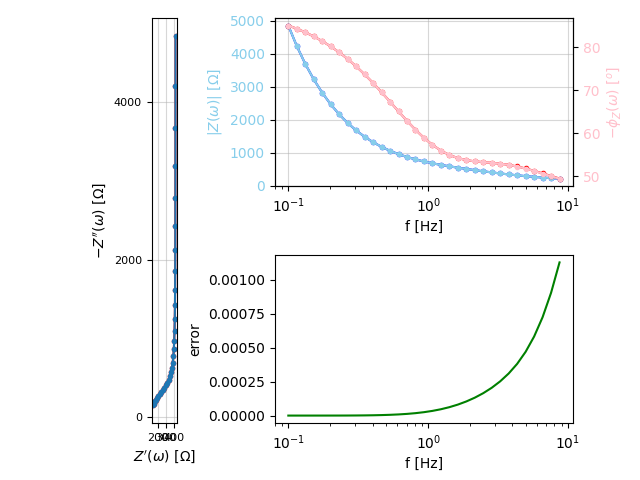

In [39]:
##-----------##
#put the nyquist and the bode plot on the same figure

fig= plt.figure()
ax_nyq=fig.add_subplot(121)
ax_mag=fig.add_subplot(222)
ax_phs=ax_mag.twinx()
ax_err=fig.add_subplot(224)

#plot nyquist plot of the taken data
plot_nyquist(z_fit,ax=ax_nyq,labelsize=10,ticksize=8,color="red")

#plot bode plot of the taken data
mag_color="blue"
phs_color="red"
ax_mag.plot(freq_to_fit, np.abs(z_fit), '.-', color=mag_color)
ax_phs.plot(freq_to_fit, -np.angle(z_fit, deg=True), '.-',color=phs_color)
ax_mag.set_ylabel(r'$|Z(\omega)|$ ' +'$[{}]$'.format("Ω"), fontsize=10,color=mag_color)
ax_phs.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10,color=phs_color)
ax_mag.set_xlabel('f [Hz]', fontsize=10)
ax_mag.set_xscale('log')
ax_mag.tick_params(axis='y', labelcolor=mag_color)
ax_phs.tick_params(axis='y', labelcolor=phs_color)
ax_mag.grid(visible=True, which='major', axis='both', alpha=.5)
fig.tight_layout()


########
##-----------##
#put the nyquist and the bode plot on the same figure

#plot nyquist plot of the taken data
plot_nyquist(zexp_to_fit,ax=ax_nyq,labelsize=10,ticksize=8)

#plot bode plot of the taken data
mag_color="SkyBlue"
phs_color="pink"
ax_mag.plot(freq_to_fit, np.abs(zexp_to_fit), '.-', color=mag_color)
ax_phs.plot(freq_to_fit, -np.angle(zexp_to_fit, deg=True), '.-',color=phs_color)
ax_mag.set_ylabel(r'$|Z(\omega)|$ ' +'$[{}]$'.format("Ω"), fontsize=10,color=mag_color)
ax_phs.set_ylabel(r'$-\phi_Z(\omega)$ ' + r'$[^o]$', fontsize=10,color=phs_color)
ax_mag.set_xlabel('f [Hz]', fontsize=10)
ax_mag.set_xscale('log')
ax_mag.tick_params(axis='y', labelcolor=mag_color)
ax_phs.tick_params(axis='y', labelcolor=phs_color)
ax_mag.grid(visible=True, which='major', axis='both', alpha=.5)
fig.tight_layout()


#plot the error plots
ax_err.plot(freq_to_fit,np.abs((zexp_to_fit-z_fit)/z_fit),color="green")
ax_err.set_ylabel("error", fontsize=10)
ax_err.set_xlabel('f [Hz]', fontsize=10)
ax_err.set_xscale('log')
print(freq_to_fit)

In [27]:
print(r'$ \omega $')

$ \omega $


In [ ]:
from models import profile_plotter 

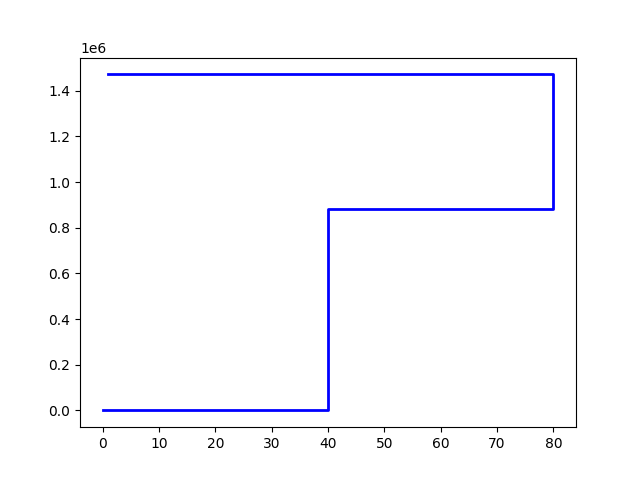

In [ ]:
fig, ax= plt.subplots()
# profile_plotter(circuit=c1,ax=ax)
profile_plotter(profile="TLMthree",circuit=cmodel,ax=ax)
circuit=cmodel
if(circuit._is_fit()):
        param=circuit.parameters_
else:
        param=circuit.initial_guess

Rref=param[0]
Q=param[1]
a=param[2]
b=param[3]

def tau_plotter(tau,ax,name):
    x=np.linspace(0,1,100)
    ax.plot(x,tau(x),label=name)

plt.show()
# print(cthree)
# ztwo1=c1.predict(frequencies=f)
# zthree1=cthree.predict(frequencies=f)
# fig, ax1 = plt.subplots()
# models.error_plotter(f,ztwo1,zthree1,ax=ax1)

### Notes
Change the print function to directly print name of the parameters
